In [74]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [75]:
import ReactiveMP.messageout

In [76]:
data_seed, params_seed = 42, 120

(42, 120)

In [77]:
include("../helpers/data.jl")
# include("../helpers/callbacks.jl")

generate_data

In [78]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [79]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [80]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [81]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h+1); H[full_order-order_h+1:full_order, 2:order_h+1] = diageye(order_h);

In [82]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [428]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    prec = 1e12;
    b = ones(order)/100;
    
    params_flow = model_params[1:end-1]
    params_w    = model_params[end]
    # initialize variables
#     θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order+1), prec*diageye(h_order+1)))}  
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow), Unscented(order)) # default: FlowMeta(model, Linearization())
    
    AR_meta = ARMeta(Multivariate, h_order+1, ARsafe())
    
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
#     w   ~ GammaShapeRate(1.0, 1.0)
    
    S = shift(order_h+1);
    c = zeros(order_h+1); c[1] = 1.0;
    
    h_prev = h_0
    for t in 1:n
        h[t] ~ MvNormalMeanPrecision(S*h_prev, melu(params_w)*c*c' + diageye(order_h+1)*prec)
        
#         h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        
        y_nodes[t], y[t] ~ y_lat_2[t] + dot(h[t], c)
        h_prev = h[t]
    end

#     return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes, θ, w
    return h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [429]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order+1), 0.1*diageye(h_order+1)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                        observations_prev, controls,
                                                                        y_order, u_order, h_order,
                                                                        options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmessages!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    setmarginals!(h, MvNormalMeanPrecision(zeros(order_h+1), diageye(order_h+1)))
    
#     setmarginal!(w, GammaShapeRate(1.0, 1.0))
#     setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order+1), diageye(h_order+1)))
    
    ProgressMeter.@showprogress for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [430]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [431]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [432]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [433]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [434]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; 1.0]

46-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -0.8271189269423392
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644
  1.0

In [435]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=50);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


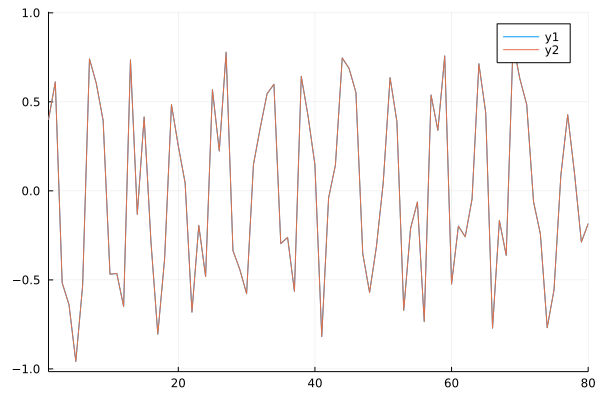

In [436]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

In [426]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=2);
    
    return fe_[end]
end;

In [427]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

LoadError: InterruptException:

In [366]:
inf_params = Optim.minimizer(res)

46-element Vector{Float64}:
 -0.9042200176828055
  1.0065095700109548
  0.013343517286536828
 -1.693028559153506
 -0.3661110746570444
  1.1524097536580535
  1.5733226048321807
 -0.6387359276243921
  1.7192886079380054
 -0.1301759849828151
 -0.6742275737694694
  0.048090149354596566
  1.6708789870581418
  ⋮
 -0.8218521209796138
 -1.2696350545345034
  0.5335662961600176
  0.9500580956237651
 -2.2494423527671152
 -1.8114687620409178
  0.6036626353157354
  0.6589950727003441
  0.2842970523767507
  0.3679330935026045
 -0.5470109240430834
  0.9999999999999998

In [403]:
fe_, h_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=50);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


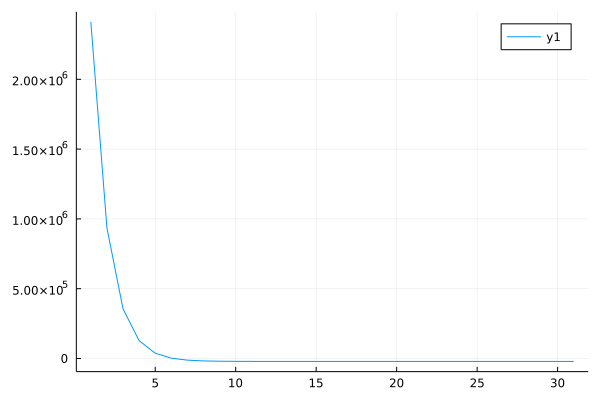

In [405]:
plot(fe_[20:50])

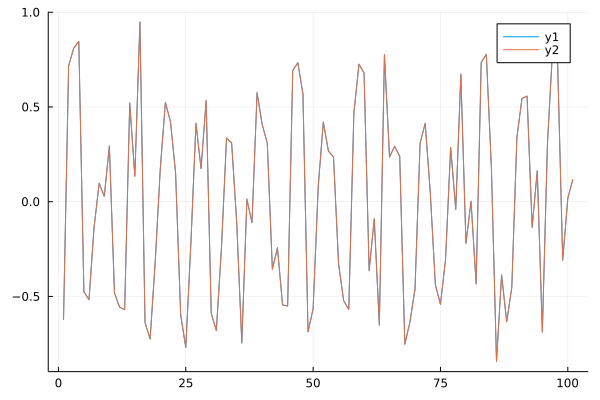

In [406]:
from, to = 100, 200
plot(mean.(y_out_[from:to]), ribbon=sqrt.(cov.(y_out_[from:to])))
plot!(Y_train[from:to])

In [416]:
mean.(h_)

800-element Vector{Vector{Float64}}:
 [0.2572419329104791, -1.5328852760495797e-9, -7.983021526995401e-10]
 [0.5512427309253509, 0.257241932881146, -1.5340885367923091e-9]
 [-0.3780371689855986, 0.5512427308777864, 0.2572419328804188]
 [-0.26553746660683925, -0.378037169031828, 0.5512427308506356]
 [-0.574996155035257, -0.2655374667542072, -0.37803716905769946]
 [-0.35663729803396177, -0.5749961550514554, -0.2655374667669276]
 [0.7373890426526652, -0.3566372979937945, -0.5749961550411351]
 [0.46881186813516923, 0.7373890425889703, -0.35663729801928906]
 [0.41664781870877954, 0.4688118680942572, 0.7373890425831635]
 [-0.19739927435841606, 0.4166478186128849, 0.46881186807164676]
 [-0.1292695958922672, -0.1973992744840329, 0.41664781858456057]
 [-0.468545504760366, -0.12926959588959294, -0.19739927449460182]
 [0.7305278372451173, -0.4685455047478035, -0.1292695958860813]
 ⋮
 [0.1380427608429648, 0.6111239842580833, 0.5291224408708344]
 [0.15720047543487847, 0.1380427607169357, 0.61112398

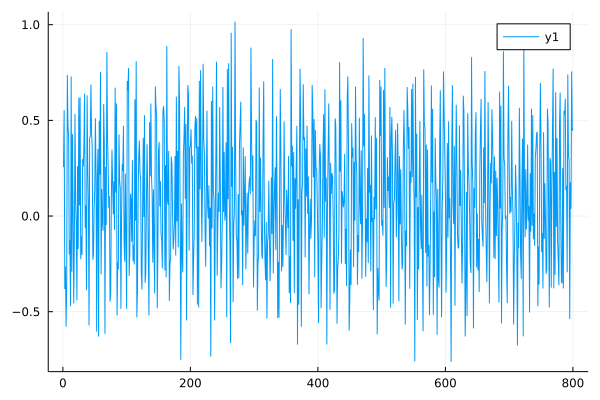

In [407]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))

In [408]:
cov.(h_)

800-element Vector{Matrix{Float64}}:
 [8.596891872778922e-14 0.0 -0.0; 0.0 4.999999999958807e-13 -7.00137228903301e-24; -0.0 -7.00137228903301e-24 9.99999999987763e-13]
 [9.510682594100881e-14 0.0 -0.0; 0.0 4.999999999970778e-13 -4.454903564700658e-24; -0.0 -4.454903564700658e-24 9.99999999992305e-13]
 [8.736022453591065e-14 0.0 -0.0; 0.0 4.999999999965265e-13 -3.220258358959549e-24; -0.0 -3.220258358959549e-24 9.99999999996378e-13]
 [1.0121548040396929e-13 0.0 -0.0; 0.0 4.999999999913555e-13 -9.382109637053599e-24; -0.0 -9.382109637053599e-24 9.999999999890604e-13]
 [9.231465041161771e-14 0.0 -0.0; 0.0 4.999999999913554e-13 -9.382148299935768e-24; -0.0 -9.382148299935768e-24 9.999999999890604e-13]
 [7.534905277942186e-14 0.0 -0.0; 0.0 4.999999999924986e-13 -8.017316196066525e-24; -0.0 -8.017316196066525e-24 9.999999999906843e-13]
 [8.315929306868627e-14 0.0 -0.0; 0.0 4.999999999859119e-13 -1.6348584983176543e-23; -0.0 -1.6348584983176543e-23 9.999999999804758e-13]
 [9.252494331690575e